# Place of Birth of the Foreign-Born Population

### Top Countries

In [05-nativity.ipynb](./05-nativity.ipynb) we saw that around a third of the residents of Great Neck are Foreign-Born. But where are they from? And has that location changed over time? To answer that we can look at [B05006: Place of Birth for the Foreign-born Population in the United States](https://censusreporter.org/data/table/?table=B05006&geo_ids=97000US3612510&primary_geo_id=97000US3612510). Let's start by looking at the most recent data:

In [11]:
from censusdis.datasets import ACS5
from censusdis.states import NY

from utils import download_multiyear

df = download_multiyear(
    dataset=ACS5,
    vintages=[2023],
    group="B05006",
    state=NY,
    school_district_unified="12510",
)
df

.

,Total,Europe,Northern Europe,Denmark,Ireland,Norway,Sweden,United Kingdom (inc. Crown Dependencies),"United Kingdom, excluding England and Scotland",England,...,Ecuador,Guyana,Peru,Uruguay,Venezuela,Other South America,Northern America,Canada,Other Northern America,Year
0,15477,1860,219,0,35,0,7,169,80,85,...,62,46,235,23,0,0,133,133,0,2023


The data is a bit hard to read in this format. Let's transpose the dataframe and then sort it:

In [14]:
(df.T.sort_values(0, ascending=False).head(11))

,0
Total,15477
Asia,11759
Eastern Asia,5746
South Central Asia,4201
China,4172
Iran,3323
"China, excluding Hong Kong and Taiwan",3161
Year,2023
Europe,1860
Americas,1506


One thing to note is that some of the columns contain aggregate data. For exampe: "Total" can be viewed as the sum of the continent rows like "Asia and "Europe". Isolating just the country-level rows it looks like China, Iran and Korea are the top countries in 2019.

It's also notable that Great Neck has roughly the same population of Foreign-Born from both China and Iran. This surprised me as a quick google search shows that in 2023 China had a population of 1.411 billion and Iran had a population is 91 million.

## Top Countries Over Time

### Naive Approach: Downloading the Entire Table

If we try to download the entire table for multiple years it fails because some of the columns have changed meaning over time:

In [15]:
df = download_multiyear(
    dataset=ACS5,
    vintages=[2009, 2016, 2023],
    group="B05006",
    state=NY,
    school_district_unified="12510",
)
df

	'Estimate!!Total!!Europe!!Northern Europe!!United Kingdom (inc. Crown Dependencies)' in [2009, 2016]
	'Estimate!!Total!!Europe!!Northern Europe!!Denmark' in [2023]


VariableMistmatchOverTime: 

### Selecting Columns

My next step was to wonder whether the columns that I actually care about have changed over the years. I am not sure the best way to do this, but after reading the [Exploring Variables](https://github.com/censusdis/censusdis/blob/main/notebooks/Exploring%20Variables.ipynb) notebook in the `censusdis` repo I realized that one way is to view the Census API pages for each (year, table) combination that I am interested in: [2023](), [2016](), [2009](https://api.census.gov/data/2009/acs/acs5/groups/B05006.html).

Searching those pages for "China", "Iran" and "Korea" you can see that: 
 * China was consistently assigned `B05006_049E`. 
 * Iran was assigned `B05006_061E` in 2023 but `B05006_060E` in 2016 and 2009.
 * Korea was consistently assigned `B05006_054E`.

The easiest way to get the merge the data from multiple years is:

In [17]:
import pandas as pd

from censusdis.datasets import ACS5
from censusdis.states import NY

df = download_multiyear(
    dataset=ACS5,
    vintages=[2009, 2016],
    download_variables=["B05006_049E", "B05006_060E", "B05006_054E"],
    state=NY,
    school_district_unified="12510",
)

df_2023 = download_multiyear(
    dataset=ACS5,
    vintages=[2023],
    download_variables=["B05006_049E", "B05006_061E", "B05006_054E"],
    state=NY,
    school_district_unified="12510",
)

df = pd.concat([df, df_2023])
df

...

,China,Iran,Korea,Year
0,1543,4424,857,2009
0,3012,4518,865,2016
0,4172,3323,1425,2023


We can graph this data using `graph_multiyear`, as before.

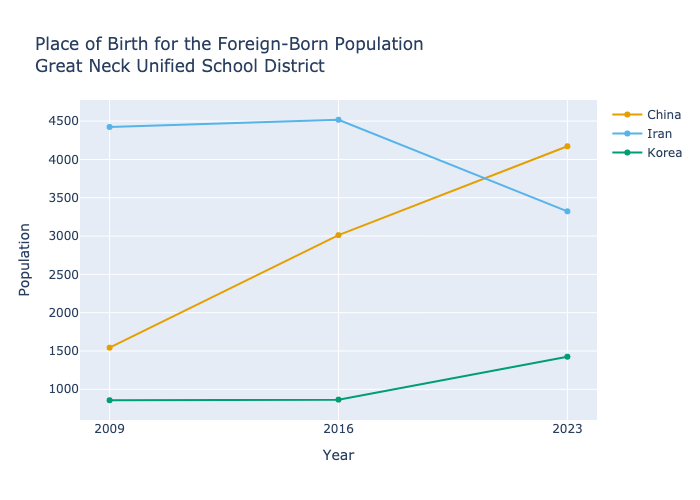

In [18]:
from utils import graph_multiyear

graph_multiyear(
    df,
    "Place of Birth for the Foreign-Born Population<br>Great Neck Unified School District",
    "Population",
)

It is a shame that the 5-year ACS only goes back to 2009 (I wish it went back to 1980, the first Census during my lifetime!). But this graph is pretty much what I was most interested in when I started this project.

Because the influx of immigrants to Great Neck was due to the Islamic Revolution of 1979, I expected that number of eventually decline. To be honest, I was surprised that it increased between 2009-2016, as the revolution was ~35 years before that. 

I had heard that there was recently an increase of immigrants from Asia, but had no idea what the numbers would be like. The fact that the number of Chinese-born immigrants recently became larger than the number of Iranian-born immigrants feels somewhat symbolic. And I can see why this was such a topic of conversation among residents when I came home.

To get a feel for the pace of change, we can convert these numbers to a percent change As before, 2009 is blank in this chart because there is nothing to compare it to.

   China  Iran  Korea  Year
0    NaN   NaN    NaN  2009
0   95.2   2.1    0.9  2016
0   38.5 -26.4   64.7  2023


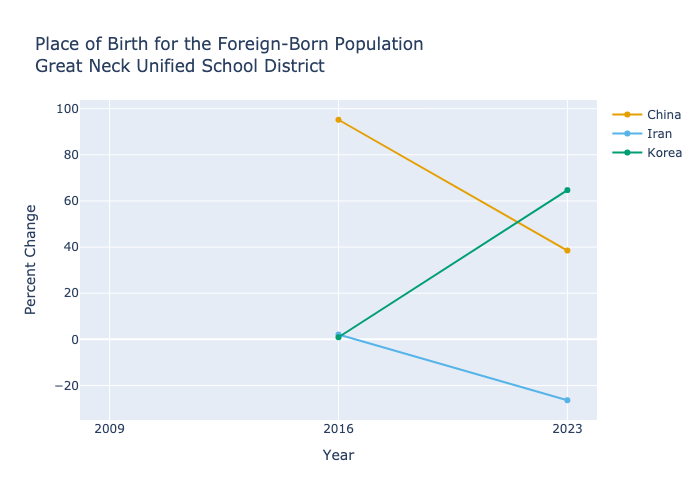

In [19]:
from utils import pct_change_multiyear

df_percent_change = pct_change_multiyear(df)
print(df_percent_change)

graph_multiyear(
    df_percent_change,
    "Place of Birth for the Foreign-Born Population<br>Great Neck Unified School District",
    "Percent Change",
)

Earlier I described it as symbolic that the number of immigrants from China is now larger than the number of immigrants from Iran. This graph makes another point: the rate of change in the number of immigrants from Korea is now higher than the rate of change in the number of immigrants from China. Although the overall number of residents from China is still much larger.